In [1913]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep
import pylab as pl

In [1914]:
nside = 64
model = 'd0s0'

In [1915]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [1916]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_freqs = freq_maps.shape[0]
n_stokes = freq_maps.shape[1]
n_pix = freq_maps.shape[2]


In [1917]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [1918]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)
M_dB_ev = M.diff_evaluator(instrument.frequency)
M_dB_dB_ev= M.diff_diff_evaluator(instrument.frequency)

In [1919]:
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)

In [1920]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))
x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40))
n_sp = len(x_init[:-n_freqs+1])

In [1921]:
dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL=0
    NA= np.einsum('ab,bc->ac', invN,A)
    AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
    AtN= np.einsum('ab,bc->ac', A.T, invN)
    P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
    dN = dati+N
    logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
    if logL != logL:
        return 0.0
    return logL

In [1922]:
bnds = ((1.4, 1.6), (19, 23), (-3.5,-2.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5))
options={'maxfun':1000000000}
result= minimize(aver_likelihood, x_init, method='TNC', tol = 1e-18, options=options, bounds=bnds )

# result.x = np.concatenate((result.x[:3],np.ones(21)))
result.x =x_true
print(result.x)

[ 1.54 20.   -3.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  ]


In [1923]:
H = nd.Hessian(aver_likelihood)
h = H(x_init) 

sigma_params_square = np.linalg.inv(h)
print(sigma_params_square)

[[ 3.82199153e-08  2.22788821e-07  3.36780915e-06  1.82750930e-06
   1.00562442e-06  4.44825067e-07  1.37706386e-07  1.33687694e-07
  -5.00220354e-08 -5.40981078e-08 -1.13928569e-07 -1.07909120e-07
  -7.93622708e-08 -4.17919794e-08 -1.08800446e-07 -7.36506007e-08
  -4.18320617e-08 -9.99627109e-09  8.97534369e-09  9.17370547e-09
   2.20784851e-08  2.71819310e-08  2.58800257e-08  2.28706770e-08]
 [ 2.22788821e-07 -8.83161646e-06 -1.94037656e-06 -1.06096880e-06
  -5.88293954e-07 -2.60879884e-07 -7.54156733e-08 -7.32146299e-08
   4.37940995e-08  4.73638661e-08  9.13644873e-08  9.16214473e-08
   7.84294541e-08  5.26102076e-08  9.23780557e-08  7.27853055e-08
   5.26606656e-08  2.52726388e-08  5.99466108e-09  6.12717591e-09
  -1.14080805e-08 -2.21264508e-08 -2.50504335e-08 -2.06988942e-08]
 [ 3.36780915e-06 -1.94037656e-06  3.36366303e-04  1.82656114e-04
   1.01249780e-04  4.61458512e-05  1.59395216e-05  1.54744482e-05
  -2.98457330e-06 -3.22759027e-06 -9.78194919e-06 -9.91860242e-06
  -8.112

In [1924]:
def _G(gain_val_arr, n_freq,known_band):
    """
    Gain matrix G
    """
    assert len(gain_val_arr) == n_freq-1
    gain_all = list(gain_val_arr)[:known_band]+[n_freq-np.sum(gain_val_arr)]+list(gain_val_arr)[known_band:] 
    
    return np.diag(gain_all)

G= _G(result.x[3:], n_freq=n_freqs, known_band=0)
print(G.shape)
print(G)

(22, 22)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

In [1925]:
def _G_dB(gain_params, n_freq, known_band):
    # this is mainly made of zeros
    G_dB = np.zeros([len(gain_params), n_freq, n_freq])
    for gi, _ in enumerate(gain_params):
        if gi >= known_band:
            fi = gi + 1
        else:
            fi = gi
        G_dB[gi, fi, fi] = 1
        G_dB[gi, known_band, known_band] = -1
    
    return G_dB

G_dB=_G_dB(result.x[3:], n_freq=n_freqs, known_band=0)
print(_G_dB(result.x[3:], n_freq=n_freqs, known_band=0).shape)
print(_G_dB(result.x[3:], n_freq=n_freqs, known_band=0))

(21, 22, 22)
[[[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  1.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  1. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  1.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  1.  0.]
  [ 0.  0.  0. 

In [1926]:
def A_ev(x):
        x_sp = x[:n_sp]
        x_gain = x[n_sp:]
        M_x = M_ev(x_sp)
        G_x = _G(x_gain, n_freqs, known_band=0)
        return np.einsum('fe, ...ec -> ...fc', G_x, M_x)

A_maxL = A_ev(result.x)
print(A_maxL.shape)

(22, 3)


In [1927]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))

comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)

residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))

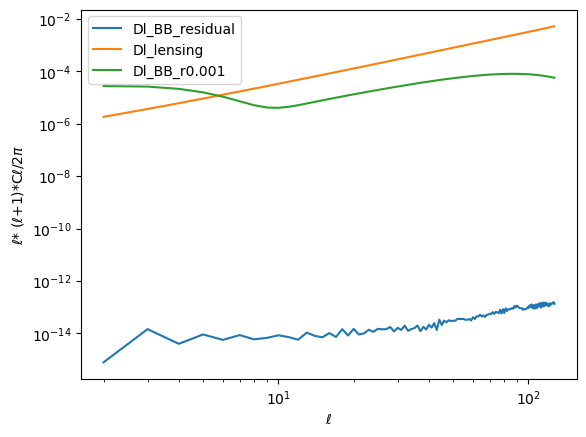

In [1928]:
#multipole range 
lmin= 2
lmax= 2*nside-1
ell = np.arange(lmin,lmax+1)


#power spectrum of the total residual 
Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:lmax+1] #with [2] I select the B mode #closed to bias
Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


#Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax+1]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax+1]

#Dl theory
Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


#lensing
Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax+1]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

#plot power spectra
plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()

In [1929]:
Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
sigma_r_fisher = np.sqrt(1.0 / F)

In [1930]:
i_cmb = M.components.index('CMB')
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]
print(W_maxL)

[-0.03041548 -0.01610321 -0.01567061 -0.00607394 -0.002387    0.00446024
  0.00294777  0.02191579  0.00399277  0.04330987  0.09867329  0.12125213
  0.06439264  0.17959845  0.15565562  0.20583402  0.11846318  0.05325374
  0.03602741  0.00161806 -0.02199437 -0.01875036]


In [1931]:
def _G_M_dB(G,M_dB):
    return np.einsum('fe, p...ec -> p...cf', G, M_dB)

def _G_dB_M(G_dB, M):
    return np.einsum('pef, ...ec -> p...cf', G_dB, M)

def _G_dB_M_dB (G_dB,M_dB):
    return np.einsum('gef, pec -> gpcf', G_dB, M_dB)

def _M_dB_G_dB (M_dB,G_dB):
    return np.einsum('pec, gef -> pgcf', M_dB, G_dB)

In [1932]:
def A_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]

    M_x = M_ev(x_sp)
    G_x = _G(x_gain, n_freqs, known_band=0)

    G_dB_x = _G_dB(x_gain, n_freqs, known_band=0)
    G_dB_M_x = _G_dB_M(G_dB_x, M_x)

    zeros=np.zeros((3,22,2))
    M_dB_x= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    G_M_dB_x = _G_M_dB(G_x, M_dB_x)
    
    print(G_dB_M_x.shape)
    print(G_M_dB_x.shape)
    
    A_dB= np.concatenate((G_M_dB_x,G_dB_M_x), axis=0)
    return A_dB

A_dB_maxL = A_dB_ev(result.x)
print(A_dB_maxL.shape)
print(A_dB_maxL)

(21, 3, 22)
(3, 3, 22)
(24, 3, 22)
[[[-1.18924180e-01 -1.40894626e-01 -1.58070439e-01 ...  4.45803358e+00
    1.35389164e+01  4.38323857e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-6.38750252e-04 -8.30757899e-04 -1.00944481e-03 ...  6.51905265e-02
    2.23713771e-01  8.18003404e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.18676968e+01 -1.82320853e+01 -9.04971730e+00 ...  3.10481776e-01
    4.39002178e-01  6.97816545e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00

In [1933]:
def A_dB_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]
    G_dB = _G_dB(x_gain, n_freqs, known_band=0)
    
    zeros=np.zeros((3,22,2))
    M_dB= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    zeros_1=np.zeros((21,22,3))
    M_dB_x= np.concatenate((M_dB,zeros_1), axis=0)

    zeros_2=np.zeros((3,22,22))
    G_dB_x=np.concatenate((G_dB,zeros_2), axis=0)


    M_dB_G_dB_x= _M_dB_G_dB (M_dB_x,G_dB_x)
    G_dB_M_dB_x=_G_dB_M_dB (G_dB_x,M_dB_x)



    M_dB_dB_x = M_dB_dB_ev(x_sp)
    M_dB_dB_x=np.array(M_dB_dB_x)

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_x[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_x[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_x[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_x[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_x[2,1][:,0]

     
    A_dB_dB= G_dB_M_dB_x + M_dB_G_dB_x + M_dB_dB_all 
    print(A_dB_dB)

    return A_dB_dB

A_dB_dB_maxL = A_dB_dB_ev(result.x)


[[[[ 3.95037091e-01 -1.27000685e-01  1.44838478e-01 ...  2.78250087e+00
     1.09590439e+01  4.32107020e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 1.19562931e-01 -8.30757899e-04 -1.58070439e-01 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 8.44271876e-04  9.12680837e-04  9.24944928e-04 ...  4.06889480e-02
     1.81084583e-01  8.06401494e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 4.19866210e+01 -1.82320853e+01  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

/Users/alicepirotta/miniforge3/envs/gain_env/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [1934]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL)
W_dB_maxL = W_dB_maxL [:, i_cmb]

[[[-4.04510412e-02 -1.99750909e-02 -1.63295211e-02 ... -4.79096730e-02
   -3.37081389e-02 -1.94901030e-05]
  [ 2.86947483e-02  1.50149700e-02  1.42293473e-02 ...  4.62868119e-03
    2.12980285e-02  1.46259060e-02]
  [ 3.96859145e-03  1.84531576e-03  1.24395053e-03 ...  8.67406030e-03
    3.66081544e-03 -1.97595449e-03]]

 [[-8.01523413e-04 -3.95344712e-04 -3.19607940e-04 ... -1.39968156e-03
   -8.36993954e-04  1.97624205e-04]
  [ 5.08493916e-04  2.65650297e-04  2.50507557e-04 ...  1.50285869e-04
    3.99354138e-04  2.28422014e-04]
  [ 9.15842059e-05  4.33387461e-05  3.06173544e-05 ...  2.51118243e-04
    1.11909800e-04 -6.63146548e-05]]

 [[ 8.00086861e-03  2.42134797e-02  4.81280590e-02 ... -1.41597418e-02
    4.00270662e-02  3.65708916e-02]
  [ 3.12813959e-03 -8.00114581e-04 -3.79895487e-03 ...  1.52223017e-03
   -1.94800866e-03 -1.96162083e-03]
  [-2.96158483e-02 -1.92255623e-02 -2.30690068e-02 ...  4.01311570e-03
   -2.74934700e-02 -2.38727833e-02]]

 ...

 [[-7.52986501e-04 -1.933

In [1935]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dB_dB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dB_dB_maxL)

print(h.shape)
print(i.shape)
print(l.shape)


p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dB_dB_maxL.T,invN)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

(24, 24, 3, 3)
(24, 24, 3, 3)
(24, 24, 3, 3)
[[[[ 3.33823060e-01  1.51595760e-01  7.30640126e-02 ... -1.08257172e+01
    -9.46113658e+00 -5.13283785e+00]
   [ 5.08210629e-01  2.67078681e-01  2.56501040e-01 ...  1.11911247e+00
     1.34136491e+00  8.06313009e-01]
   [ 1.07477621e-01  6.38175117e-02  8.15741015e-02 ...  1.95001781e+00
     1.82973916e+00  1.03303305e+00]]

  [[ 6.52973214e-03  2.62893596e-03 -2.04221100e-03 ... -2.05368984e-01
    -1.80433180e-01 -9.78551726e-02]
   [ 5.00857365e-04  2.04498858e-04  3.52947850e-04 ...  2.21022065e-02
     1.93028338e-02  9.53916475e-03]
   [ 1.15357495e-03  7.98432554e-04  1.69749356e-03 ...  3.68606714e-02
     3.42003443e-02  1.91994311e-02]]

  [[-1.89435209e-01 -3.18952777e-01 -4.66683677e-02 ...  1.70222860e+01
     1.58274992e+01  9.02098205e+00]
   [ 2.49617126e-01  1.59217062e-01  1.64951055e-01 ... -1.96544622e+00
    -1.93205466e+00 -1.12815785e+00]
   [ 2.13758398e-01  1.53370753e-01  1.00356532e-01 ... -3.03614041e+00
    -2.

In [1936]:
if n_stokes == 3:  
    d_spectra = freq_maps
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, freq_maps.shape[2]), dtype=freq_maps.dtype)
    d_spectra[:, 1:] = freq_maps

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [1937]:
V_maxL = np.einsum('ij,ij...->...', sigma_params_square, W_dB_dB_maxL)


# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]== W_dB_dB_maxL.shape[2:] == V_maxL.shape)
assert (len(result.x) == W_dB_maxL.shape[0] == W_dB_dB_maxL.shape[0] == W_dB_dB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)



Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz']
stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])

(2, 127)

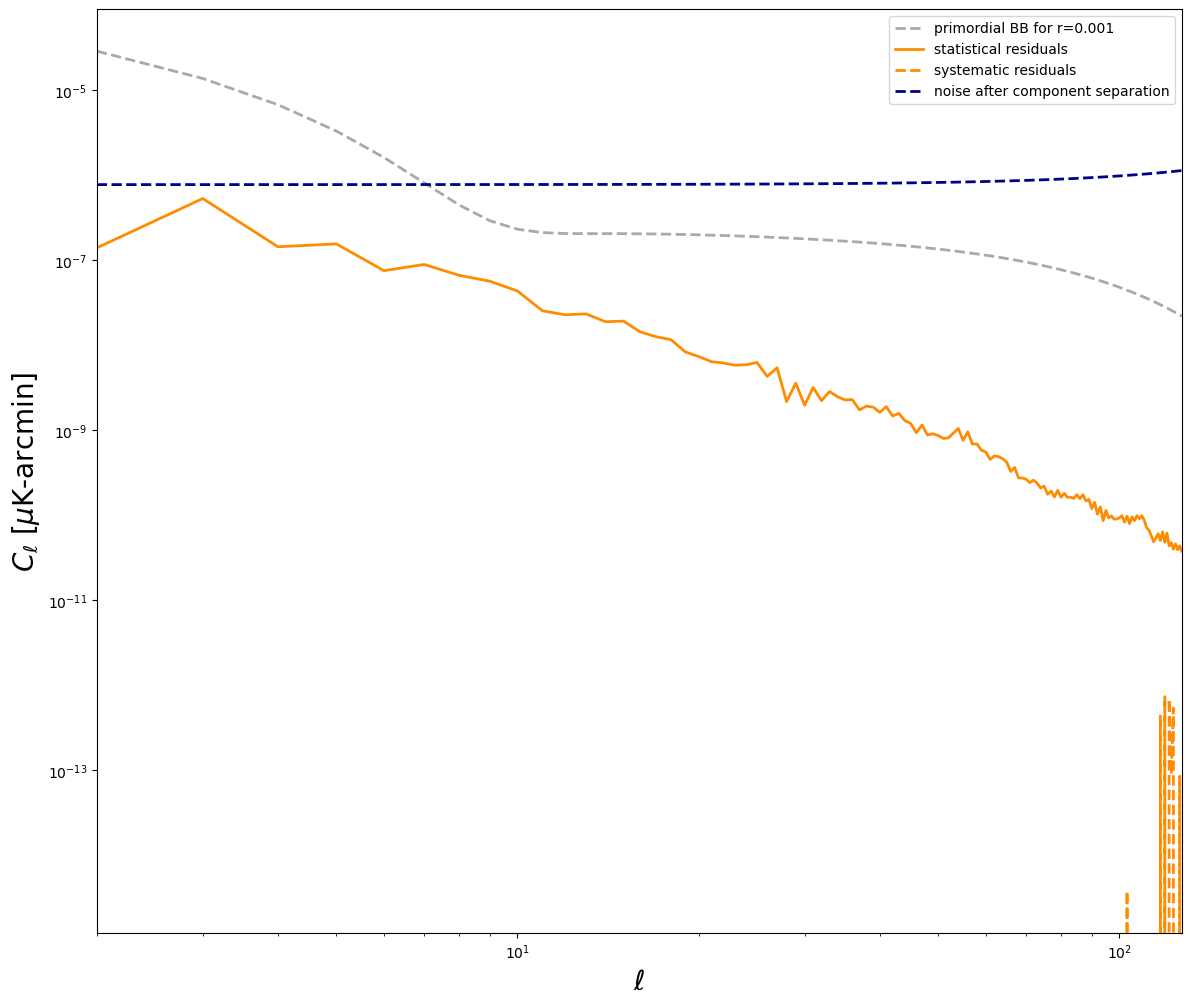

In [1938]:
lmin= 2
lmax= 127
ell = np.arange(lmin, lmax+1)


Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=0.1, r=0.001)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]



fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]

# ax.loglog(ell, Cl_BB_r_001, color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_BB_r_001 , color='DarkGray', linestyle='--', label='primordial BB for r='+str(0.001), linewidth=2.0)
ax.loglog(ell, stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
# ax.loglog(ell, Cl_BB_residual, 'DarkGreen', linestyle='--', label='residual', linewidth=1.0)
ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
ax.set_xlim(lmin,lmax)